In [25]:
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+
import re
import math
from pyspark.sql.window import Window
from pyspark.sql import SparkSession, functions, types
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor,DecisionTreeRegressor,GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.feature import MinMaxScaler
import pandas as pd
spark = SparkSession.builder.appName('example code').getOrCreate()
assert spark.version >= '2.4' # make sure we have Spark 2.4+
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext
spark.conf.set('spark.sql.session.timeZone', 'UTC')

bitcoin_schema = types.StructType([
    types.StructField('Date', types.StringType()),
    types.StructField('Symbol', types.StringType()),
    types.StructField('Open', types.FloatType()),
    types.StructField('High', types.FloatType()),
    types.StructField('Low', types.FloatType()),
    types.StructField('Close', types.FloatType()),
    types.StructField('Volume BTC', types.FloatType()),
    types.StructField('Volume USD', types.FloatType()),
])
tweets_schema = types.StructType([
    types.StructField('Date', types.StringType()),
    types.StructField('tweet', types.StringType())
])

In [26]:
col_order = ["timestamp", "Open", "High", "Low", "Close", "Volume BTC", "Volume USD"]
tweet_col = ['negative', "neutral", "positive", "compound"]

In [72]:
bitcoin_df = spark.read.csv("bitcoin-usd-history.csv", schema=bitcoin_schema).na.drop().cache()
bitcoin_df = bitcoin_df.withColumn("timestamp", functions.unix_timestamp("Date", 'yyyy-MM-dd hh-aa').cast("timestamp")).drop('Date')
bitcoin_df = bitcoin_df.select(col_order).where(
    (functions.unix_timestamp(functions.lit('2019-11-17 00:00:00')).cast('timestamp') > bitcoin_df["timestamp"]) & 
    (bitcoin_df["timestamp"] >= functions.unix_timestamp(functions.lit('2019-11-14 00:00:00')).cast('timestamp'))).sort("timestamp").cache()
bitcoin_df = bitcoin_df.select(functions.hour("timestamp").alias("hour"), "Close", functions.date_trunc('dd', "timestamp").alias('date')).cache()
bitcoin_df.show(26)

+----+-------+-------------------+
|hour|  Close|               date|
+----+-------+-------------------+
|   0|9019.76|2019-11-14 00:00:00|
|   1| 9024.4|2019-11-14 00:00:00|
|   2|8978.68|2019-11-14 00:00:00|
|   3| 9024.5|2019-11-14 00:00:00|
|   4|8946.14|2019-11-14 00:00:00|
|   5|8931.31|2019-11-14 00:00:00|
|   6| 8972.2|2019-11-14 00:00:00|
|   7| 8926.0|2019-11-14 00:00:00|
|   8| 8861.0|2019-11-14 00:00:00|
|   9|8884.04|2019-11-14 00:00:00|
|  10|8873.13|2019-11-14 00:00:00|
|  11|8906.35|2019-11-14 00:00:00|
|  12|8877.01|2019-11-14 00:00:00|
|  13| 8961.0|2019-11-14 00:00:00|
|  14|8948.84|2019-11-14 00:00:00|
|  15|8923.47|2019-11-14 00:00:00|
|  16|8922.01|2019-11-14 00:00:00|
|  17|8927.97|2019-11-14 00:00:00|
|  18|8913.35|2019-11-14 00:00:00|
|  19|8903.64|2019-11-14 00:00:00|
|  20|8939.67|2019-11-14 00:00:00|
|  21|8905.13|2019-11-14 00:00:00|
|  22|8887.42|2019-11-14 00:00:00|
|  23|8903.94|2019-11-14 00:00:00|
|   0|8909.81|2019-11-15 00:00:00|
|   1|8815.67|2019-1

In [39]:
tweet_df = spark.read.csv("tweets", schema=tweets_schema)
tweet_df = tweet_df.withColumn("timestamp", functions.unix_timestamp("Date", 'yyyy-MM-dd HH:mm:ss').cast("timestamp")).drop('Date')
tweet_df = tweet_df.select("timestamp", "tweet").sort("timestamp").cache()
tweet_df = tweet_df.na.drop()

tweet_df.show(3)

+-------------------+--------------------+
|          timestamp|               tweet|
+-------------------+--------------------+
|2019-11-14 00:00:01|b'11/14 09:00\xe7...|
|2019-11-14 00:00:02|b'BitcoinAverage ...|
|2019-11-14 00:00:02|b'\xe3\x80\x90Our...|
+-------------------+--------------------+
only showing top 3 rows



In [40]:
import preprocessor as p
@functions.udf(returnType=types.StringType())
def func_udf(input_str):
    input_str = re.sub(r'b', '', input_str)
    p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)
    input_str = p.clean(input_str)
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", input_str).split())
# func_udf = udf(function_udf, StringType())
#     return p.clean(input_str)
    return intput_str
CleanDF = tweet_df.withColumn('CleanedTweets', func_udf(tweet_df['tweet'])).drop("tweet")
CleanDF.show(3)

+-------------------+--------------------+
|          timestamp|       CleanedTweets|
+-------------------+--------------------+
|2019-11-14 00:00:01|11 14 09 00 xe7 x...|
|2019-11-14 00:00:02|BitcoinAverage it...|
|2019-11-14 00:00:02|xe3 x80 x90Our Lo...|
+-------------------+--------------------+
only showing top 3 rows



In [43]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

@functions.udf(returnType=types.ArrayType(types.FloatType()))
def senti_score(sentence):
    snt = analyser.polarity_scores(sentence)
    return ([snt['neg'], snt['neu'], snt['pos'], snt['compound']])

CleanDF = CleanDF.withColumn('negative', senti_score(CleanDF['CleanedTweets'])[0])
CleanDF = CleanDF.withColumn('neutral', senti_score(CleanDF['CleanedTweets'])[1])
CleanDF = CleanDF.withColumn('positive', senti_score(CleanDF['CleanedTweets'])[2])
CleanDF = CleanDF.withColumn('compound', senti_score(CleanDF['CleanedTweets'])[3])
CleanDF.show(20)

+-------------------+--------------------+--------+-------+--------+--------+
|          timestamp|       CleanedTweets|negative|neutral|positive|compound|
+-------------------+--------------------+--------+-------+--------+--------+
|2019-11-14 00:00:01|11 14 09 00 xe7 x...|     0.0|    1.0|     0.0|     0.0|
|2019-11-14 00:00:02|BitcoinAverage it...|     0.0|    1.0|     0.0|     0.0|
|2019-11-14 00:00:02|xe3 x80 x90Our Lo...|     0.0|   0.74|    0.26|  0.8176|
|2019-11-14 00:00:02|MercadoBitcoin BT...|     0.0|  0.636|   0.364|  0.6486|
|2019-11-14 00:00:02|The Bitcoin BTC p...|     0.0|    1.0|     0.0|     0.0|
|2019-11-14 00:00:02|Bitcoin BTC nPric...|     0.0|    1.0|     0.0|     0.0|
|2019-11-14 00:00:03|BTCUSD ALERT 24hr...|   0.099|  0.768|   0.133|   0.186|
|2019-11-14 00:00:03|New Topic Top Sen...|    0.22|  0.709|   0.071| -0.5859|
|2019-11-14 00:00:03|NOW SHILLING PEPE...|     0.0|    1.0|     0.0|     0.0|
|2019-11-14 00:00:04|A new post Uncork...|     0.0|    1.0|     

In [66]:
GroupDF = CleanDF.sort("timestamp").withColumn("hour", functions.hour("timestamp")+1).withColumn("day", functions.date_trunc('dd', "timestamp"))
GroupDF.show()

+-------------------+--------------------+--------+-------+--------+--------+----+-------------------+
|          timestamp|       CleanedTweets|negative|neutral|positive|compound|hour|                day|
+-------------------+--------------------+--------+-------+--------+--------+----+-------------------+
|2019-11-14 00:00:01|11 14 09 00 xe7 x...|     0.0|    1.0|     0.0|     0.0|   1|2019-11-14 00:00:00|
|2019-11-14 00:00:02|BitcoinAverage it...|     0.0|    1.0|     0.0|     0.0|   1|2019-11-14 00:00:00|
|2019-11-14 00:00:02|xe3 x80 x90Our Lo...|     0.0|   0.74|    0.26|  0.8176|   1|2019-11-14 00:00:00|
|2019-11-14 00:00:02|MercadoBitcoin BT...|     0.0|  0.636|   0.364|  0.6486|   1|2019-11-14 00:00:00|
|2019-11-14 00:00:02|The Bitcoin BTC p...|     0.0|    1.0|     0.0|     0.0|   1|2019-11-14 00:00:00|
|2019-11-14 00:00:02|Bitcoin BTC nPric...|     0.0|    1.0|     0.0|     0.0|   1|2019-11-14 00:00:00|
|2019-11-14 00:00:03|BTCUSD ALERT 24hr...|   0.099|  0.768|   0.133|   0.

In [70]:
# GroupDF.sort("hour").show(25)
GroupDF = GroupDF.groupBy('day', 'hour').agg(functions.mean('negative').alias('negative'), functions.mean('neutral').alias('neutral'), functions.mean('positive').alias('positive'), functions.mean('compound').alias('compound')).cache()
GroupDF.sort("day", 'hour').show(26)


+-------------------+----+--------------------+------------------+-------------------+-------------------+
|                day|hour|            negative|           neutral|           positive|           compound|
+-------------------+----+--------------------+------------------+-------------------+-------------------+
|2019-11-14 00:00:00|   1| 0.02353443532730594| 0.904154269655874|0.07231955914745318|0.12222231390883444|
|2019-11-14 00:00:00|   2| 0.02700937503250316|0.8911062504164875|0.08188749979017303|0.13332531208870932|
|2019-11-14 00:00:00|   3| 0.02580503150586437| 0.903097484659099|0.07111006277267756|0.12360282942840138|
|2019-11-14 00:00:00|   4|0.020909968128733313|0.9099581977562122|0.06914469453587026|  0.138334726142155|
|2019-11-14 00:00:00|   5|0.021063545301407076|0.8948729094055584|0.08407357860867395| 0.1703842790006196|
|2019-11-14 00:00:00|   6|0.022349845341207812|0.9002476776531976|0.07742105273316519| 0.1588634673748223|
|2019-11-14 00:00:00|   7|0.022160891

In [81]:
w =Window.partitionBy('day').orderBy(functions.col("hour").cast('long'))
join_df = GroupDF.join(bitcoin_df, (GroupDF["hour"] == bitcoin_df["hour"])&(GroupDF['day']==bitcoin_df['date'])).select(GroupDF["*"],bitcoin_df["Close"])
# join_df = join_df.sort("hour").withColumn("Price", functions.lag("Close", count=-1).over(w))
join_df = join_df.select("hour", "day", "Close", "negative", "neutral", "positive", "compound").na.drop()

In [82]:
join_df.sort("day", "hour").show(24)

+----+-------------------+-------+--------------------+------------------+-------------------+-------------------+
|hour|                day|  Close|            negative|           neutral|           positive|           compound|
+----+-------------------+-------+--------------------+------------------+-------------------+-------------------+
|   1|2019-11-14 00:00:00| 9024.4| 0.02353443532730594| 0.904154269655874|0.07231955914745318|0.12222231390883444|
|   2|2019-11-14 00:00:00|8978.68| 0.02700937503250316|0.8911062504164875|0.08188749979017303|0.13332531208870932|
|   3|2019-11-14 00:00:00| 9024.5| 0.02580503150586437| 0.903097484659099|0.07111006277267756|0.12360282942840138|
|   4|2019-11-14 00:00:00|8946.14|0.020909968128733313|0.9099581977562122|0.06914469453587026|  0.138334726142155|
|   5|2019-11-14 00:00:00|8931.31|0.021063545301407076|0.8948729094055584|0.08407357860867395| 0.1703842790006196|
|   6|2019-11-14 00:00:00| 8972.2|0.022349845341207812|0.9002476776531976|0.0774

In [83]:
for feature in tweet_col:
    for diff in range(1, 4):
        name = feature + "_lag_{}".format(diff)
        join_df = join_df.withColumn(name, functions.lag(join_df[feature], count=diff).over(w))

join_df = join_df.na.drop()
join_df.show(2)

+----+-------------------+-------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+
|hour|                day|  Close|            negative|           neutral|           positive|           compound|      negative_lag_1|      negative_lag_2|     negative_lag_3|     neutral_lag_1|     neutral_lag_2|     neutral_lag_3|     positive_lag_1|     positive_lag_2|     positive_lag_3|    compound_lag_1|    compound_lag_2|     compound_lag_3|
+----+-------------------+-------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+---

In [85]:
join_df.select("hour", "day", "Close").show(40)

+----+-------------------+-------+
|hour|                day|  Close|
+----+-------------------+-------+
|   4|2019-11-16 00:00:00|8774.53|
|   5|2019-11-16 00:00:00| 8779.0|
|   6|2019-11-16 00:00:00|8768.66|
|   7|2019-11-16 00:00:00|8759.11|
|   8|2019-11-16 00:00:00| 8773.6|
|   9|2019-11-16 00:00:00|8792.58|
|  10|2019-11-16 00:00:00|8792.42|
|  11|2019-11-16 00:00:00|8767.85|
|  12|2019-11-16 00:00:00|8779.67|
|  13|2019-11-16 00:00:00|8770.65|
|  14|2019-11-16 00:00:00|8767.61|
|  15|2019-11-16 00:00:00| 8792.0|
|  16|2019-11-16 00:00:00|8789.78|
|  17|2019-11-16 00:00:00|8764.79|
|  18|2019-11-16 00:00:00| 8765.0|
|  19|2019-11-16 00:00:00|8761.04|
|  20|2019-11-16 00:00:00|8764.53|
|  21|2019-11-16 00:00:00|8779.13|
|  22|2019-11-16 00:00:00|8767.18|
|  23|2019-11-16 00:00:00|8774.37|
|   4|2019-11-14 00:00:00|8946.14|
|   5|2019-11-14 00:00:00|8931.31|
|   6|2019-11-14 00:00:00| 8972.2|
|   7|2019-11-14 00:00:00| 8926.0|
|   8|2019-11-14 00:00:00| 8861.0|
|   9|2019-11-14 00:

In [87]:
featureCols = []
for feature in tweet_col:
    featureCols.append(feature)
    for diff in range(1, 4):
        featureCols.append(feature + "_lag_{}".format(diff))
featureCols

['negative',
 'negative_lag_1',
 'negative_lag_2',
 'negative_lag_3',
 'neutral',
 'neutral_lag_1',
 'neutral_lag_2',
 'neutral_lag_3',
 'positive',
 'positive_lag_1',
 'positive_lag_2',
 'positive_lag_3',
 'compound',
 'compound_lag_1',
 'compound_lag_2',
 'compound_lag_3']

In [88]:
train, validation = join_df.randomSplit([0.75, 0.25])
train = train.cache()
validation = validation.cache()
train.show(2)

+----+-------------------+-------+--------------------+------------------+-------------------+------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+
|hour|                day|  Close|            negative|           neutral|           positive|          compound|      negative_lag_1|     negative_lag_2|      negative_lag_3|     neutral_lag_1|     neutral_lag_2|     neutral_lag_3|     positive_lag_1|     positive_lag_2|     positive_lag_3|     compound_lag_1|    compound_lag_2|     compound_lag_3|
+----+-------------------+-------+--------------------+------------------+-------------------+------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+----

In [100]:
assembler = VectorAssembler(
        inputCols= featureCols,
        outputCol='features'

)

regressor = GBTRegressor(featuresCol = 'features', labelCol = 'Close')

In [101]:
pipeline = Pipeline(stages=[assembler, regressor])
model = pipeline.fit(train)

In [102]:
predictions = model.transform(validation)
someDF = predictions.select("prediction", "Close").show(5)

+-----------------+-------+
|       prediction|  Close|
+-----------------+-------+
|8949.581874857779| 8779.0|
|8917.387806871973|8759.11|
| 8933.05939666426| 8773.6|
| 8768.33745460605|8779.67|
|8934.780148528755|8789.78|
+-----------------+-------+
only showing top 5 rows



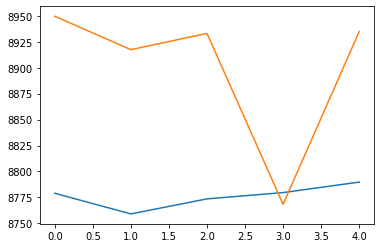

In [103]:
predictions = predictions.toPandas().head()
plt.plot(predictions['Close'])
plt.plot(predictions['prediction'])
plt.show()

In [92]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="r2")
score = evaluator.evaluate(predictions)

print('R square error is: %g' % (score))

R square error is: -0.883336


In [ ]:
from pyspark.sql import Row
Person = [Row('name', 'age'), ]
person = rdd.map(lambda r: Person(*r))
df2 = spark.createDataFrame(person)